# Proyek: Analisis Prediksi Churn Telco
## Notebook 00: Business & Data Understanding

**Fase CRISP-ML(Q):** 1. Business Understanding, 2. Data Understanding

**Tujuan:**
1.  Mendefinisikan pertanyaan bisnis yang ingin kita jawab (Business Understanding).
2.  Melakukan Exploratory Data Analysis (EDA) untuk memahami data mentah, menemukan anomali, dan mengidentifikasi pola awal (Data Understanding).

## Fase 1: Business Understanding

Tujuan bisnis utama dari dataset ini adalah **Manajemen Retensi Pelanggan**.

Kita akan mendefinisikan 4 pertanyaan bisnis utama yang akan dijawab oleh alur kerja kita:

1.  **[Klasifikasi & XAI]** Fitur apa yang paling kuat mendorong *churn*? Bisakah kita membangun model yang akurat untuk memprediksi nasabah yang berisiko *churn*?
2.  **[Analisis Biaya]** Dengan asumsi biaya retensi (False Positive) dan biaya kehilangan nasabah (False Negative) berbeda, model klasifikasi mana yang memberikan **profitabilitas** terbaik?
3.  **[Regresi]** Bisakah kita memprediksi `TotalCharges` (sebagai *proxy* Customer Lifetime Value) dari seorang nasabah?
4.  **[Clustering]** Tanpa mengetahui `Churn` atau `TotalCharges`, adakah segmen pasar (persona) alami di dalam basis nasabah kita?

## Fase 2: Data Understanding (EDA)

Kita akan memuat data mentah dan melakukan EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mengatur style visualisasi
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


### 2.1 Pemuatan Data

Kita memuat data dari `data/raw/` (sesuai `README.md`). Kita ubah manual namanya `telco_churn.csv`.

In [2]:
RAW_DATA_PATH = '../data/raw/telco_churn.csv'

try:
    df = pd.read_csv(RAW_DATA_PATH)
    print(f"Data loaded successfully from {RAW_DATA_PATH}")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {RAW_DATA_PATH}")
    print("Harap unduh dataset dari Kaggle dan letakkan di 'data/raw/' dengan nama 'telco_churn.csv'")

Data loaded successfully from ../data/raw/telco_churn.csv
Shape: (7043, 21)


### 2.2 Inspeksi Awal (Tipe Data & Anomali)

In [3]:
print("--- Data Info (Tipe & Non-Null) ---")
df.info()

--- Data Info (Tipe & Non-Null) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperl

**Temuan Kritis #1: Anomali `TotalCharges`**

Kita langsung menemukan masalah besar. `TotalCharges` (yang seharusnya numerik) terdaftar sebagai tipe `object` (string). Ini akan merusak semua pemodelan kita jika tidak ditangani.

Ini biasanya terjadi karena ada nilai non-numerik (seperti spasi " " atau "N/A") di dalam kolom tersebut. Kita akan memperbaikinya sekarang.

In [4]:
# 1. Konversi 'TotalCharges' ke numerik. 'errors=\'coerce\'' akan mengubah string yang salah (seperti " ") menjadi NaN (Missing Value).
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Cek berapa banyak missing values yang dihasilkan
missing_charges = df['TotalCharges'].isnull().sum()
print(f"'TotalCharges' sekarang menjadi numerik.")
print(f"Jumlah missing values yang ditemukan (dari string ' '): {missing_charges}")

# 3. Kita lihat data yang hilang itu
print("\nData dengan TotalCharges yang hilang:")
print(df[df['TotalCharges'].isnull()][['customerID', 'tenure', 'TotalCharges']])

'TotalCharges' sekarang menjadi numerik.
Jumlah missing values yang ditemukan (dari string ' '): 11

Data dengan TotalCharges yang hilang:
      customerID  tenure  TotalCharges
488   4472-LVYGI       0           NaN
753   3115-CZMZD       0           NaN
936   5709-LVOEQ       0           NaN
1082  4367-NUYAO       0           NaN
1340  1371-DWPAZ       0           NaN
3331  7644-OMVMY       0           NaN
3826  3213-VVOLG       0           NaN
4380  2520-SGTTA       0           NaN
5218  2923-ARZLG       0           NaN
6670  4075-WKNIU       0           NaN
6754  2775-SEFEE       0           NaN


**Temuan:**
Data yang hilang tersebut adalah nasabah dengan `tenure` (masa berlangganan) = 0 bulan. Masuk akal jika `TotalCharges` mereka kosong.

**Keputusan:** Karena jumlahnya sangat kecil (~11 baris) dan mereka adalah nasabah baru yang belum punya sejarah, kita akan **menghapus** baris-baris ini dari analisis kita.

In [5]:
# Kita buang baris dengan TotalCharges = NaN
df_clean = df.dropna(subset=['TotalCharges']).copy()

print(f"Shape lama: {df.shape}")
print(f"Shape baru setelah dropna: {df_clean.shape}")

print("\n--- Data Info (Setelah Perbaikan) ---")
df_clean.info()

Shape lama: (7043, 21)
Shape baru setelah dropna: (7032, 21)

--- Data Info (Setelah Perbaikan) ---
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 

### 2.3 Analisis Variabel Target (`Churn`)

Sekarang data kita bersih, mari kita periksa variabel target kita.

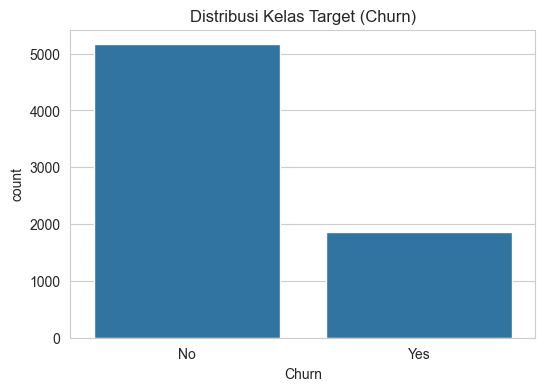

Distribusi Kelas Target:
Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_clean)
plt.title('Distribusi Kelas Target (Churn)')
plt.show()

print("Distribusi Kelas Target:")
print(df_clean['Churn'].value_counts(normalize=True))

**Temuan Kritis #2: Data Tidak Seimbang (Imbalanced)**

Hanya **26.6%** nasabah kita yang *churn* (Kelas Positif), sementara 73.4% tetap bertahan (Kelas Negatif). 

**Hipotesis Pemodelan:**
1.  Metrik `accuracy` akan sangat menyesatkan.
2.  Kita **wajib** menggunakan metrik seperti **ROC-AUC** dan **Precision-Recall**.
3.  Kita perlu menggunakan teknik penanganan data imbalanced, seperti `class_weight='balanced'` pada model kita atau `stratify=y` saat melakukan `train_test_split`.

### 2.4 Analisis Fitur Kategorikal Kunci

Fitur apa yang paling membedakan *churner* dan *non-churner*?

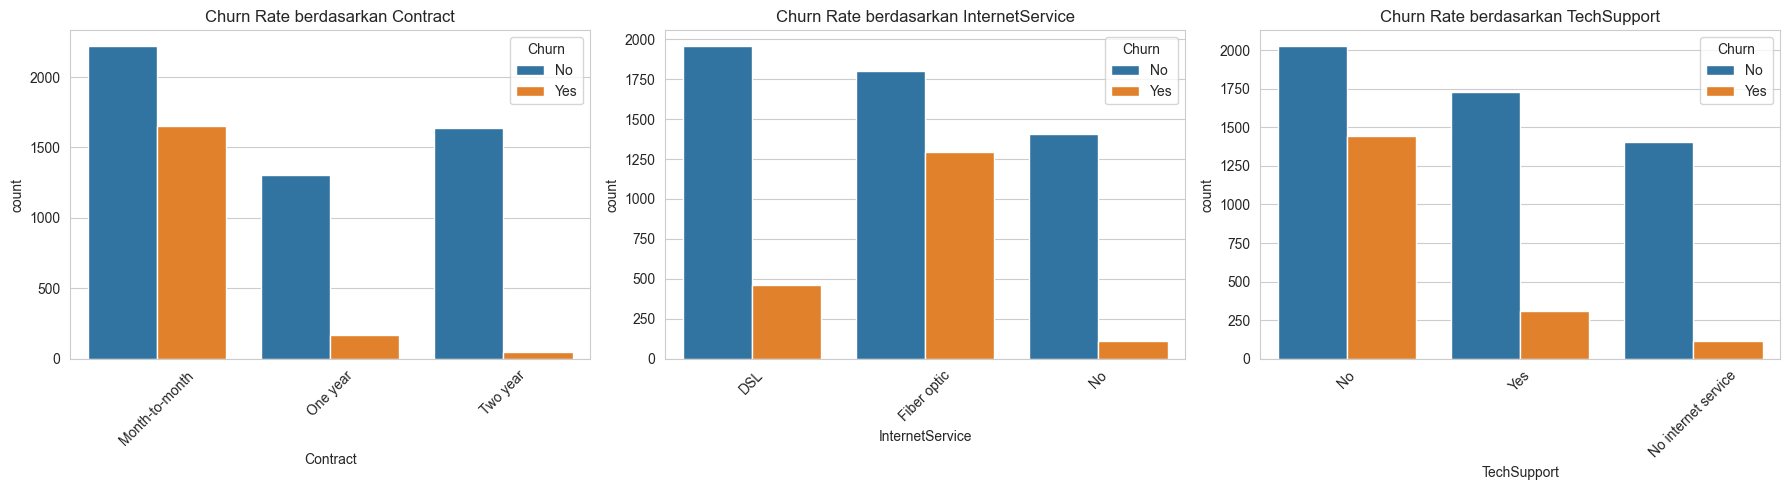

In [7]:
# Kita akan memplot 3 fitur yang paling mungkin memengaruhi churn
key_categorical_features = ['Contract', 'InternetService', 'TechSupport']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(key_categorical_features):
    sns.countplot(ax=axes[i], x=feature, data=df_clean, hue='Churn')
    axes[i].set_title(f'Churn Rate berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

**Temuan Kunci (Hipotesis Fitur):**

* **`Contract`:** Ini adalah prediktor terkuat. Nasabah `Month-to-month` memiliki rasio *churn* yang sangat tinggi. Nasabah `Two year` hampir tidak pernah *churn*.
* **`InternetService`:** Nasabah `Fiber optic` memiliki tingkat *churn* yang jauh lebih tinggi daripada `DSL`. Ini adalah *insight* bisnis yang menarik (mungkin fiber-nya tidak stabil atau terlalu mahal?).
* **`TechSupport`:** Nasabah dengan `No` *tech support* memiliki tingkat *churn* yang sangat tinggi.

### 2.5 Analisis Fitur Numerik (`tenure`, `MonthlyCharges`)

Bagaimana fitur numerik berhubungan dengan *churn*?

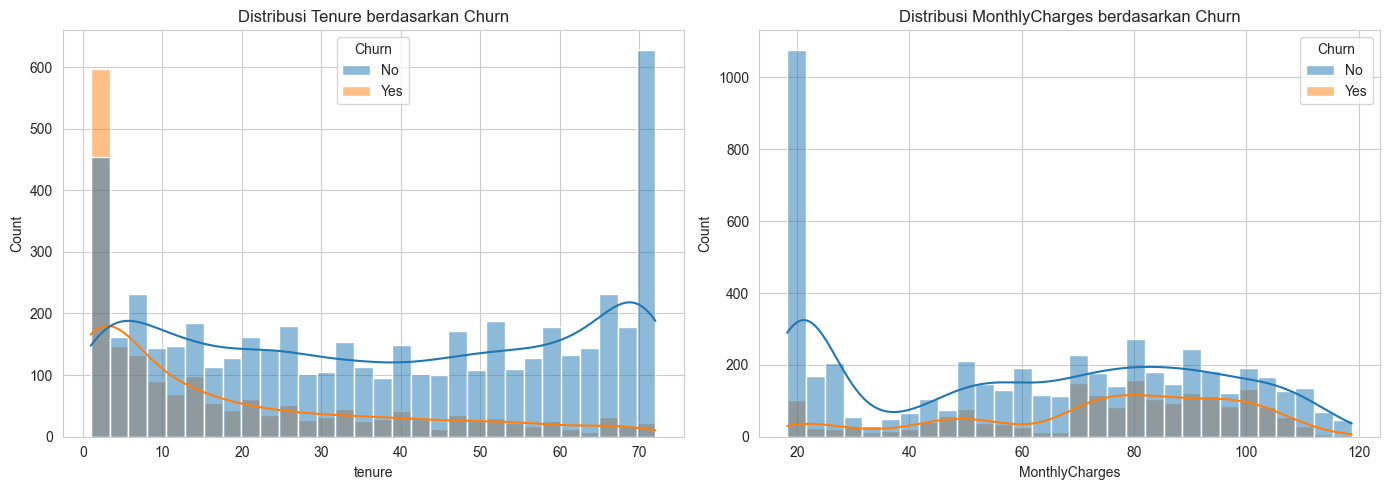

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Tenure (Masa Berlangganan)
sns.histplot(ax=axes[0], data=df_clean, x='tenure', hue='Churn', kde=True, bins=30)
axes[0].set_title('Distribusi Tenure berdasarkan Churn')

# Plot 2: MonthlyCharges
sns.histplot(ax=axes[1], data=df_clean, x='MonthlyCharges', hue='Churn', kde=True, bins=30)
axes[1].set_title('Distribusi MonthlyCharges berdasarkan Churn')

plt.tight_layout()
plt.show()

**Temuan Kunci (Hipotesis Fitur):**

* **`tenure`:** Ada korelasi negatif yang kuat. Nasabah baru (`tenure` rendah, puncak di kiri) adalah yang paling mungkin *churn*. Nasabah lama (`tenure` tinggi, puncak di kanan) sangat setia.
* **`MonthlyCharges`:** Ada korelasi positif. Nasabah yang *churn* (oranye) cenderung memiliki tagihan bulanan yang lebih tinggi.

## Kesimpulan Fase 0 & 1

Kita telah menyelesaikan Fase Business & Data Understanding.

**Hipotesis Utama untuk Pemodelan:**
1.  **Data Quality:** Data bersih, **kecuali** `TotalCharges` yang perlu dikonversi ke numerik dan baris `NaN`-nya (11 baris) dihapus.
2.  **Imbalance:** Target `Churn` tidak seimbang (73/27). Kita harus menggunakan **ROC-AUC** dan **`stratify`**.
3.  **Key Predictors:** Fitur terkuat untuk memprediksi *churn* adalah:
    * `Contract` (Month-to-month)
    * `tenure` (Rendah)
    * `InternetService` (Fiber optic)
    * `TechSupport` (No)

Kita siap untuk **Langkah 01: Data Preparation** (prototipe *pipeline*).